# Computer Hardware Data Set
The goal is estimating computer relative performance from its hardware data (e.g. machine cycle time in nanoseconds).</br>
The data set is got from [here](http://archive.ics.uci.edu/ml/datasets/Computer+Hardware).

### Details of data column
- vendor name: 30 
- Model Name: many unique symbols
- MYCT: machine cycle time in nanoseconds (integer)
- MMIN: minimum main memory in kilobytes (integer)
- MMAX: maximum main memory in kilobytes (integer)
- CACH: cache memory in kilobytes (integer)
- CHMIN: minimum channels in units (integer)
- CHMAX: maximum channels in units (integer)
- PRP: published relative performance (integer)
- ERP: estimated relative performance from the original article (integer)

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

### Read data

In [158]:
df = pd.read_csv("./data/machine-data.csv")
estimated_performance = df["ERP"]
df = df.drop(columns=["vendor", "model", "ERP"])
df

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,125,256,6000,256,16,128,198
1,29,8000,32000,32,8,32,269
2,29,8000,32000,32,8,32,220
3,29,8000,32000,32,8,32,172
4,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...
204,124,1000,8000,0,1,8,42
205,98,1000,8000,32,2,8,46
206,125,2000,8000,0,2,14,52
207,480,512,8000,32,0,0,67


### Watching correlation of each column

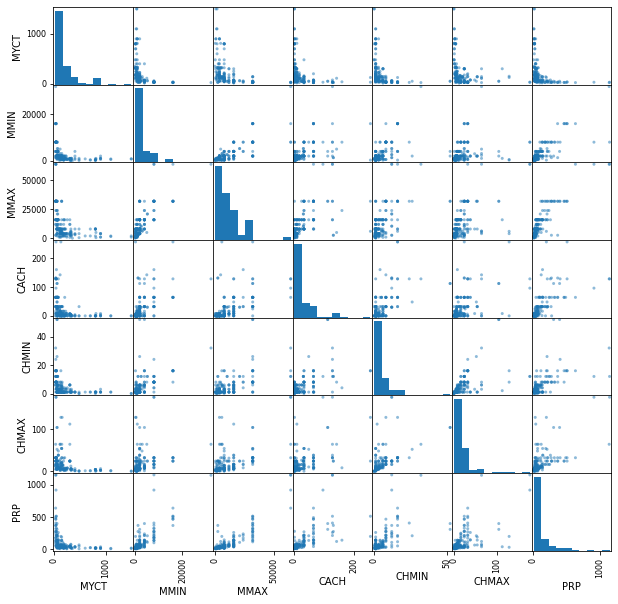

In [180]:
pd.plotting.scatter_matrix(df, figsize=(10, 10))
plt.show()

### Split data into random train and test subsets

In [160]:
data_num = df.shape[0]
target = df["PRP"].to_numpy()
data = df.drop(columns="PRP").to_numpy()

# split train and test data
mask = np.random.rand(data_num) < 0.8
train_X = data[mask]
train_y = target[mask]

test_X = data[~mask]
test_y = target[~mask]

### Build a polynomial regression model
This is a polynomial regression model for estimating relative computer performance. The input data (hereinafter referred to as X) shape is "data size" x "the number of parameters".


#### Points
- normalize data with min-max normalization.
- optimize the weights by solving normal equation when the inverse matrix of (X.T @ X) exists.
  - when it doesn't, optimizing with gradient descent


In [239]:
class PolynomialRegression:
    def __init__(self, degree, epoch, lr=0.001):
        self.degree = degree
        self.epoch = epoch
        self.lr = lr

    def transform(self, X):
        # initialize X_transform
        X_transformed = np.hstack((np.ones((X.shape[0], 1)), X))
        for i in range(1, self.degree):
            X_transformed = np.hstack((X_transformed, np.power(X, i + 1)))
        return X_transformed

    def normalize(self, X):
        return (X - self.min) / self.max

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        # use the same min-max normalize at the prediction process
        self.min = X.min(axis=0, keepdims=True)
        self.max = X.max(axis=0, keepdims=True)
        # initialize weights
        X_normalized = self.normalize(X)
        X_transformed = self.transform(X_normalized)

        # solve normal equation
        if np.linalg.det(X_transformed.T @ X_transformed) != 0:
            self.W = np.linalg.inv(X_transformed.T @ X_transformed) @ X_transformed.T @ y
            print("solve analytically")

        # solve with gradient descent
        else:
            self.W = np.random.rand(X_transformed.shape[1], 1)
            for _ in range(self.epoch):
                y_hat = self.predict(X_transformed, is_train=True)
                error = y_hat - y
                self.W -= self.lr * np.dot(X_transformed.T, error)
            print("solve numerically")

    def predict(self, X, is_train=False):
        if not is_train:
            X_normalized = self.normalize(X)
            X = self.transform(X_normalized)
        return np.dot(X, self.W)


def RMSE(predict, gt):
    return np.log(np.sum(np.power(predict - gt, 2)) / gt.shape[0])


#### Solve with linear regression (use identity function as basis function)

In [240]:
model = PolynomialRegression(degree=1, lr=0.00001, epoch=1000)
model.fit(train_X, train_y)
y_hat = model.predict(test_X)
error = RMSE(y_hat, test_y)

solve analytically


#### Solve with polynomial regression (degree = 2)

In [241]:
model_poly2 = PolynomialRegression(degree=2, lr=0.00001, epoch=1000)
model_poly2.fit(train_X, train_y)
y_hat_poly2 = model_poly2.predict(test_X)
error_poly2 = RMSE(y_hat_poly2, test_y)

solve analytically


In [242]:
model_poly5 = PolynomialRegression(degree=5, lr=0.00001, epoch=1000)
model_poly5.fit(train_X, train_y)
y_hat_poly5 = model_poly5.predict(test_X)
error_poly5 = RMSE(y_hat_poly5, test_y)

solve analytically


#### Use $\log$ as a basis function

In [243]:
train_epsilon = np.zeros_like(train_X) + 0.000000001
train_X_log = np.log(train_X + train_epsilon)

test_epsilon = np.zeros_like(test_X) + 0.000000001
test_X_log = np.log(test_X + test_epsilon)

In [244]:
model_log = PolynomialRegression(degree=1, lr=0.0001, epoch=500)
model_log.fit(train_X_log, train_y)
y_hat_log = model_log.predict(train_X_log)
error_log = RMSE(y_hat_log, test_y)

solve analytically


#### Use sigmoid function as a basis function

In [245]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

train_X_sigmoid = sigmoid(train_X)
test_X_sigmoid = sigmoid(test_X)

In [246]:
model_sigmoid = PolynomialRegression(degree=1, lr=0.0001, epoch=500)
model_sigmoid.fit(train_X_sigmoid, train_y)
y_hat_sigmoid = model_sigmoid.predict(train_X_sigmoid)
error_sigmoid = RMSE(y_hat_sigmoid, test_y)

solve numerically


## Compare various methods

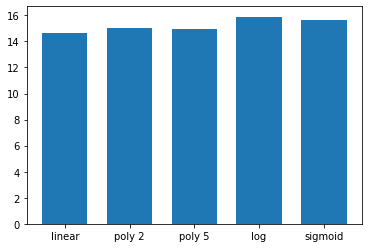

In [247]:
plt.bar(range(5), [error, error_poly2, error_poly5, error_log, error_sigmoid], tick_label=["linear", "poly 2", "poly 5",  "log", "sigmoid"], width=0.7)
plt.show()

### Conclusion

In this experiment, the simplest linear regression model is the best model for this task.